Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Madhavi Pagare"
COLLABORATORS = "N/A"

---

# Programming Assignment 2
* CSCI-5931 : Deep Learning
* Spring 2022
* Instructor: Ashis Kumer Biswas


In [1]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

In [2]:
"""
Setting work environment with dataset. If on Google colaboratory, we need to extract dataset stored in google drive,
otherwise the dataset is already there.
"""
try:
    from google.colab import drive
    print('Running on Google colab...')
    drive.mount('/content/drive')
    import zipfile
    with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/csci5931sp22/PA2-dataset/Archive.zip', 'r') as zip_ref:
        zip_ref.extractall('dataset/')
except:
    print('Running on local machine...')

Running on local machine...


In [3]:
# === Imports === #
# Various python packages are used in this notebook. Please get yourself used to them (optional).
import pandas as pd  # used for storing a tabular representation of the dataset, similar to XLS files.
from pathlib import Path # used to check if the saved model files and accessories.
import requests #used to request remote judge.csv evaluation 
from sklearn.preprocessing import StandardScaler  # used for normalization of dataset
from sklearn.preprocessing   import LabelBinarizer    # used for splitting the gender column
from sklearn.preprocessing   import MinMaxScaler      # used for normalization of dataset
from sklearn.model_selection import train_test_split  # used for performing the train-test split of a dataframe
import cv2                                            # OpenCV used for image processing
import random   #random number generator
import datetime #used to get current date/time
import math     #math/numerical functions
import os       #os specific functions, like file open/close etc.
import gc       #garbage collection module -- used to manually clean up memory spaces/references.


from sklearn.preprocessing import OneHotEncoder   #My favorite categorical to numerical feature conversion tool
from tensorflow import keras  # keras used for construction of the Artificial neural network
from keras.models import Sequential #keras model architectures
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten,Dropout, BatchNormalization #types of layers
from keras.losses import mean_squared_error, huber, log_cosh  #built-in loss 
from tensorflow.python.keras.saving import hdf5_format  #used for saving models 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard  #callbacks
from keras.models import model_from_json  #used for loading model architecture from json file
import h5py  #saved model type

import matplotlib.pyplot as plt  # used for training visualization
import numpy as np  # numpy arrays used for matrix computations

# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0: #If you have at least one "configured" GPU, let's use it; otherwise, pass
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# === Random Seed Initialization === #
random_seed = 54321  # will be passed into every function which accepts a random seed/state
                     # so that, all submissions will produce the same output.
Path("saved_models/").mkdir(parents=True, exist_ok=True)  #create a directory to save model files

## Task 0: Preprocessing Data (10 points)


### Read the data about the image dataset

Let's read the data about the image dataset from `dataset/wiki_labels.csv`.

In [4]:
wiki_labels = pd.read_csv( 'dataset/wiki_labels.csv' )
wiki_labels.head( ) #printing first 5 rows from the metadata

,ID,dob,dob_str,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,age
0,2002,723671,['05-May-1981'],2009,['17/10000217_1981-05-05_2009.png'],1.0,['Sami Jauhojärvi'],[[111.29109473 111.29109473 252.66993082 252.6...,4.300962388,NaN,27.746119
1,2003,711677,['03-Jul-1948'],2008,['12/100012_1948-07-03_2008.png'],1.0,['Marc Okrand'],[[113.52 169.84 366.08 422.4 ]],4.329328832,NaN,59.582192
2,2004,705061,['23-May-1930'],1961,['65/10001965_1930-05-23_1961.png'],1.0,['Aleksandar Matanović'],[[ 1 1 634 440]],#NAME?,NaN,30.696804
3,2005,720044,['31-May-1971'],2012,['16/10002116_1971-05-31_2012.png'],0.0,['Diana Damrau'],[[171.61031405 75.5745124 266.76611571 170.7...,3.408442415,NaN,40.672146
4,2006,716189,['09-Nov-1960'],2012,['02/10002702_1960-11-09_2012.png'],0.0,['Krista Tippett'],[[274.7656324 57.77009008 376.88699455 159.8...,4.748056378,NaN,51.224201


You will notice the metadata has 11 columns namely:

1. **ID**: identification number of the subject (starting from 2002)
2. **dob**: the date of birth of the subject. (It is Matlab’s datenum value calculated based on total number of days since January 0, 0000.)
3. **dob_str**: the DD-MMM-YYYY format dob value.
4. **photo_taken**: when the photo was taken (only the year value)
5. **full_path**: directory path, including filename of the image
6. **gender**: Gender of the subject (0: female, 1: male, NaN if unknown)
7. **name**: name of the subject
8. **face_location**: location of the face.
9. **face_score**: detector score (the higher the better). `Inf` implies that no face was found in the image, and the `face_location` then just returns the entire image.
10. **second_face_score**: detector score of the face with the second highest score. This is useful to ignore images with more than one face. `second_face_score` is NaN (not a number) if no second face was detected.
11. **age**: age of the person (in years), and was calculated based on the “dob” value and the “photo_taken” values.

### Cleaning dataset
1. **First note about the dataset**: Some rows in the training dataset have an age of 0 because the image doesn't correspond to a person's face. In order to counter this dirty data, we need to remove these bad rows from the dataset as we intend to build models to predict age of a person from a given photo/portrait of the person.

2. **Second note about the dataset**: The `face_score` attribute have the chance of containing `"#NAME?"` which is likely meant to represent non-face image samples. We need to remove these too. 

In [5]:
def clean_dataset(data):
    '''
    This function takes the wiki_labels type pandas.DataFrame as the data input.
    Then returns a cleaned dataframe following the 2 notes mentioned above in the description.
    
    '''
     #https://www.dataquest.io/blog/machine-learning-preparing-data/
    #https://machinelearningmastery.com/basic-data-cleaning-for-machine-learning/
     # YOUR CODE HERE
    data = data.loc[data["age"]!=0]
    data = data.loc[data["face_score"]!="#NAME?"]
    return data

In [6]:
assert len(wiki_labels)==60327

assert len(clean_dataset(wiki_labels))==42855

### Loading image dataset

In [7]:
#lean the wiki_labels information dataset.
wiki_labels_clean = clean_dataset(wiki_labels)

#Extract the path & target ['age'] for the input images
X_paths = wiki_labels_clean['full_path']
y_age = wiki_labels_clean['age']

#Finally, train-test split (80-20)
X_train_paths,X_test_paths, y_train, y_test = train_test_split(X_paths,y_age,test_size=0.2,shuffle=random_seed)

In [8]:
#Now load the images
#All images are 100x100 resolution. Let's pre-allocate the image container for efficiency purpose
X_train_images = np.zeros( shape = (len(X_train_paths),100,100),dtype=np.float32)

i = 0
for p in X_train_paths:
    p = p.replace('[','').replace(']','').replace('\'','')
    fpath = '{}/{}'.format('dataset/wiki_labeled/',p)
    X_train_images[i] = cv2.imread(fpath,cv2.IMREAD_GRAYSCALE) / 255.0  #load & scale
    i += 1


#Reshaping to fit for Keras Tensor usage
X_train_images = X_train_images.reshape(
    X_train_images.shape[0],
    X_train_images.shape[1],
    X_train_images.shape[2],
    1
)


In [9]:
#Now load the test images
#All images are 100x100 resolution. Let's pre-allocate the image container for efficiency purpose
X_test_images = np.zeros( shape = (len(X_test_paths),100,100),dtype=np.float32)

i = 0
for p in X_test_paths:
    p = p.replace('[','').replace(']','').replace('\'','')
    fpath = '{}/{}'.format('dataset/wiki_labeled/',p)
    X_test_images[i] = cv2.imread(fpath,cv2.IMREAD_GRAYSCALE) / 255.0
    i += 1

X_test_images = X_test_images.reshape(
    X_test_images.shape[0],
    X_test_images.shape[1],
    X_test_images.shape[2],
    1
)

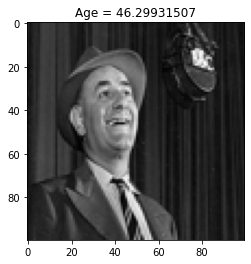

In [11]:
#Pick a random number and display it.
idx = random.randint(0,X_train_images.shape[0])
img = X_train_images[idx]
plt.figure()
plt.imshow(img.squeeze(), cmap='gray')
plt.title('Age = {}'.format(y_train.iloc[idx]))
plt.show()

## Task 1: Model 1:: Building your first Convolution Neural Network (CNN) model (10pts)

Let's build your first convolution neural network (CNN), CNN_A with the following configuration:

* Following is the sequential structure:
    - size of the Kernels used in all `Conv2D` layers is (3,3), padding=`valid` 
    - `pool_size` of (2,2) was used in all of `MaxPool2D` layers.
* Select `activation` for all the units in the CNN architecture "wisely". Keras provides a good number of activation functions. Details can be obtained here [Keras.layers activations](https://keras.io/api/layers/activations/)


Model: "sequential"

| Layer type| Output Shape | Param # (roughly)|
| :----------- | :----------- |------------|
|Conv2D   |          (None, 98, 98, 32)  |      320       |
| MaxPooling2D |  (None, 49, 49, 32)  |     0      |   
| Conv2D           | (None, 47, 47, 64)   |     18496    | 
| MaxPooling2D |  (None, 23, 23, 64) |      0        |
| Conv2D           | (None, 21, 21, 128)  |     73856     |
| MaxPooling2D | (None, 10, 10, 128) |     0          |                                       
| Flatten     |      (None, 12800)   |          0      |   
| Dense          |     (None, 64)       |         819264   | 
| Dropout       |    (None, 64)        |        0         |
| Dense         |    (None, 1)          |       65  |

In [30]:
def my_CNN_model_A(loss,optimizer,metrics):
    model = Sequential()
    #https://github.com/sagar448/Keras-Convolutional-Neural-Network-Python
 #https://github.com/mingruimingrui/Convolution-neural-networks-made-easy-with-keras/blob/master/basic_model.py
     
    # YOUR CODE HERE
    model.add(Conv2D(32, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='tanh'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='tanh'))
    model.add(MaxPool2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    # finally, compile with the provided optimizer to optimize the given loss object.
    # Also, list of metrics are going to be computed during each epoch.
    model.compile(loss=loss, 
                  optimizer=optimizer,
                  metrics=metrics)
    return model

* Use `mean_squared_error` as the loss function for this problem. It is one of the built-in Keras loss function.
    * Details about it can be obtained here [Keras loss function](https://keras.io/api/losses/regression_losses/)
* Use `adam` as the optimizer. It is one of the built-in Keras optimizer for backpropagation/gradient descent. Details can be found here [Keras optimizers](https://keras.io/api/optimizers/)
* Make sure to print the 4 metrics during every training epochs: 'mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error',  'cosine_similarity', 'logcosh'. Details about the metrics defined in Keras can be found here [Keras metrics](https://keras.io/api/metrics/regression_metrics/)



In [13]:
# I've called my_CNN_model_A() function following the requirements above. 
# Please take a careful note at how it was called.
model1 = my_CNN_model_A(loss='mean_squared_error',
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

In [14]:
# Calling summary() to see if the model architecture requirements are met or not.
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

In [15]:
def check_network_architecture(model, expected_layer_shapes, 
                               expected_params,
                               expected_loss_function
                              ):
    #This function checks a model's basic architecture
    layer_shapes = []
    for layer in model.layers:
        layer_shapes.append(layer.output_shape)

    so_far_so_good = False
    if layer_shapes == expected_layer_shapes:
        if model.count_params()==expected_params:
            if model.loss == expected_loss_function:
                so_far_so_good = True
    return so_far_so_good

In [16]:
"""Check if the network is compiled according to the specification"""

assert  check_network_architecture(model1, 
                                  expected_layer_shapes=[(None, 98, 98, 32), (None, 49, 49, 32), (None, 47, 47, 64), (None, 23, 23, 64), (None, 21, 21, 128), (None, 10, 10, 128), (None, 12800), (None, 64), (None, 64), (None, 1)],
                                  expected_params=912001,
                                  expected_loss_function='mean_squared_error') == True

In [17]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

epochs = 50  #number of epochs to run the training on
batch_size = 128 #batch size

#Train and test dataset for the training & validation
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#prefix to model names for saving
model_path = 'saved_models/model1.sav'

#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

In [35]:
def lets_train_model(model, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks=callbacks):
    #This function must call the model.fit() function with appropriate parameters:
    #
    # Input parameters:
    # x_train, y_train : are the training set prepared above
    # epochs : number of epochs to run (unless early stopping callback kicks in)
    # batch_size : the batch_size to use during weight update (mini-batch gradient descent)
    # x_test, y_test : to be passed as validation_data to validate the partially trained model after each epoch
    # callbacks : the list of 4 callbacks prepared in the previous cell to be passed to the fit() function
    #
    # Returns a list of the following 2:
    #  history : return value of model.fit() call
    #  model   : the fit model
     # YOUR CODE HERE
        #https://github.com/sagar448/Keras-Convolutional-Neural-Network-Python
        #https://github.com/vzhou842/cnn-from-scratch/blob/master/cnn_keras.py
#https://github.com/DIAGNijmegen/StreamingCNN/blob/master/Imagenette%20example.ipynb
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=callbacks)
    
    return [history, model]

In [20]:
# Now, call the lets_train_model() above with appropriate parameters to train model1.
# Please store the list of [history, model1] returned from the call.
# YOUR CODE HERE
#https://github.com/sg-nm/cgp-cnn/blob/master/cnn_train.py
#https://github.com/huggingface/transformers/blob/master/src/transformers/trainer.py

history, model1 = lets_train_model(model1, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks=callbacks)

Epoch 1/50
268/268 [==============================] - 12s 46ms/step - loss: 319.3321 - mean_absolute_percentage_error: 41.9562 - mean_absolute_error: 13.9224 - mean_squared_logarithmic_error: 0.1865 - cosine_similarity: 1.0000 - logcosh: 13.2437 - val_loss: 283.2129 - val_mean_absolute_percentage_error: 40.4715 - val_mean_absolute_error: 13.5437 - val_mean_squared_logarithmic_error: 0.1713 - val_cosine_similarity: 1.0000 - val_logcosh: 12.8640 - lr: 1.0000e-04
Epoch 2/50
268/268 [==============================] - 12s 45ms/step - loss: 318.9924 - mean_absolute_percentage_error: 41.8177 - mean_absolute_error: 13.8898 - mean_squared_logarithmic_error: 0.1861 - cosine_similarity: 1.0000 - logcosh: 13.2118 - val_loss: 283.2168 - val_mean_absolute_percentage_error: 40.4634 - val_mean_absolute_error: 13.5427 - val_mean_squared_logarithmic_error: 0.1713 - val_cosine_similarity: 1.0000 - val_logcosh: 12.8630 - lr: 1.0000e-04
Epoch 3/50
268/268 [==============================] - 12s 45ms/step - 

In [21]:
# checking if the training was successful
assert( all(key in history.history for key in ('loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh', 'val_loss', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error', 'val_mean_squared_logarithmic_error', 'val_cosine_similarity', 'val_logcosh')))
#assert(len(history.history['loss'])==epochs)


In [38]:
# Save model
def save_model(model_path, model, name, description):
    # This function takes the prefix of the model_path and a name and description as input
    # and saves the architecture as a json file and weights as additional file.
    # The best model is already saved by the mcp_callback during the fit() call with extension *.mcp.hdf5
    
    # Step 1: serialize model architecture to *.json file
    model_json = model.to_json()
    with open(model_path+".json", "w") as json_file:
        json_file.write(model_json)

    #Step 2: now the model weights + additional attributes as *.additional
    with h5py.File(model_path+'.additional', mode='w') as f:
        hdf5_format.save_model_to_hdf5(model, f)
        f.attrs['name'] = name
        f.attrs['description'] = description


In [39]:
#load model
def load_model(model_path):
    # This function loads from the 3 files: *.json, *.additional, *.mcp.hdf5 located at the model_path prefix
    # and returns the best model, it's name and description
    
    mode = []
    name = 'NA'
    descripton = 'NA'
    with open(model_path+'.json', 'r') as json_file:
        loaded_model_json = json_file.read()
        model = model_from_json(loaded_model_json) #load the architecture
        model.load_weights(model_path+'.mcp.hdf5') #load the weights (from the ModelCheckPoint)
        
        with h5py.File(model_path+'.additional', mode='r') as f: #load the additional name/description info
            name = f.attrs['name']
            description = f.attrs['description']
    return [model, name, description]

In [24]:
# Saving model1
save_model(model_path, model=model1, name='Model1', description='CNN-A with built-in MSE loss')

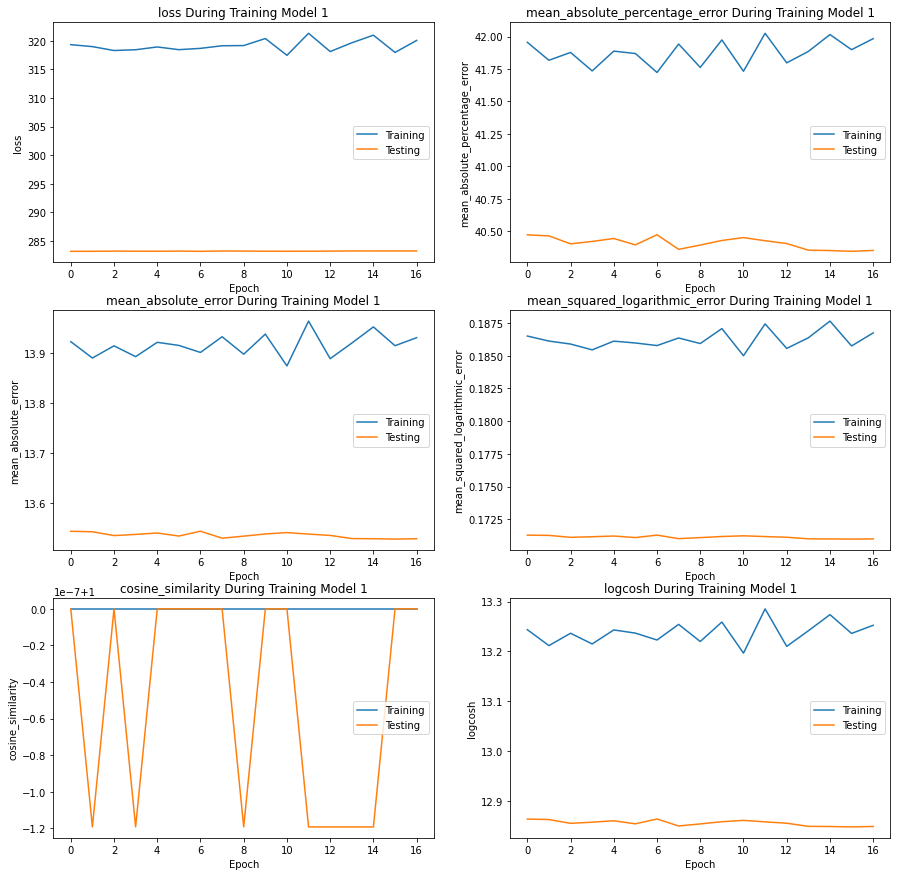

In [25]:
# === Plot the model1 training and validation performance === #
metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Model 1' )
    plt.legend( )

# === Display the Chart === #
plt.show( )

In [26]:
# a little memory management -- mandatory if eager-execution is enabled
del model1
gc.collect()


22508

## Task 2: Model 2:: Second Convolution Neural Network (CNN) model (10pts)

Let's build your second convolution neural network (CNN), CNN_B with the following configuration:

* Following is the sequential structure:
    - size of the Kernels used in all `Conv2D` layers is (3,3), padding=`valid` 
    - `pool_size` of (2,2) was used in all of `MaxPool2D` layers.
* Select `activation` for all the units in the CNN architecture "wisely". Keras provides a good number of activation functions. Details can be obtained here [Keras.layers activations](https://keras.io/api/layers/activations/)



Model: "sequential"

| Layer type| Output Shape | Param # (roughly)|
| :----------- | :----------- |------------|
|Conv2D   |          (None, 98, 98, 32)  |      320       |
| BatchNormalization |  (None, 98, 98, 32) |      128    |       
| Dropout      |  (None, 98, 98, 32)  |      0 |
| MaxPooling2D |  (None, 49, 49, 32)  |     0      |   
| Conv2D           | (None, 47, 47, 64)   |     18496    |
| BatchNormalization | (None, 47, 47, 64) |       256   |        
| Dropout      |        (None, 47, 47, 64) |       0   | 
| MaxPooling2D |  (None, 23, 23, 64) |      0        |
| Conv2D           | (None, 21, 21, 128)  |     73856     |
| BatchNormalization |  (None, 21, 21, 128) |     512    |       
| Dropout      |  (None, 21, 21, 128)  |     0   |
| MaxPooling2D | (None, 10, 10, 128) |     0          |                                       
| Flatten     |      (None, 12800)   |          0      |   
| Dense          |     (None, 64)       |         819264   | 
| Dropout       |    (None, 64)        |        0         |
| Dense         |    (None, 1)          |       65  |

In [27]:
def my_CNN_model_B(loss,optimizer,metrics):
    model = Sequential()
    
    #https://github.com/sagar448/Keras-Convolutional-Neural-Network-Python
#https://gist.github.com/JiaxiangZheng/a60cc8fe1bf6e20c1a41abc98131d518
#https://github.com/vzhou842/cnn-from-scratch/blob/master/cnn_keras.py
    
    # YOUR CODE HERE
    model.add(Conv2D(32, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(MaxPool2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(MaxPool2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(MaxPool2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    # finally, compile with the provided optimizer to optimize the given loss object.
    # Also, list of metrics are going to be computed during each epoch.
    model.compile(loss=loss, 
                  optimizer=optimizer,
                  metrics=metrics)

    # finally, compile with the provided optimizer to optimize the given loss object.
    # Also, list of metrics are going to be computed during each epoch.
    model.compile(loss=loss, 
                  optimizer=optimizer,
                  metrics=metrics)
    return model

* Use `mean_squared_error` as the loss function for this problem. It is one of the built-in Keras loss function. Details about it can be obtained here [Keras loss function](https://keras.io/api/losses/regression_losses/)
* Use `adam` as the optimizer. It is one of the built-in Keras optimizer for backpropagation/gradient descent. Details can be found here [Keras optimizers](https://keras.io/api/optimizers/)
* Make sure to print the 4 metrics during every training epochs: 'mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error',  'cosine_similarity', 'logcosh'. Details about the metrics defined in Keras can be found here [Keras metrics](https://keras.io/api/metrics/regression_metrics/)



In [28]:
# I've called my_CNN_model_B() function following the requirements above. 
# Please take a careful note at how it was called.
model2 = my_CNN_model_B(loss='mean_squared_error',
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

In [29]:
"""Check if the network is compiled according to the specification"""

assert  check_network_architecture(model2, 
                                  expected_layer_shapes=[(None, 98, 98, 32), (None, 98, 98, 32), (None, 98, 98, 32), (None, 49, 49, 32), (None, 47, 47, 64), (None, 47, 47, 64), (None, 47, 47, 64), (None, 23, 23, 64), (None, 21, 21, 128), (None, 21, 21, 128), (None, 21, 21, 128), (None, 10, 10, 128), (None, 12800), (None, 64), (None, 64), (None, 1)],
                                  expected_params=912897,
                                  expected_loss_function='mean_squared_error') == True

In [30]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

epochs = 50 #num of epochs
batch_size = 128 #batch size

#train-test datasets ready to be trained
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#prefix to the model save path
model_path = 'saved_models/model2.sav'

#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]


In [32]:
# Now, call the lets_train_model() above with appropriate parameters to train model2.
# Please store the list of [history, model2] returned from the call.
#https://github.com/FunctionLab/selene/blob/master/selene_sdk/train_model.py
#https://github.com/udacity/CN-ML_SageMaker_Studies/blob/master/Project_Plagiarism_Detection/source_pytorch/train.py
# YOUR CODE HERE
history, model2 = lets_train_model(model2, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks=callbacks)

Epoch 1/50
268/268 [==============================] - 22s 80ms/step - loss: 773.8372 - mean_absolute_percentage_error: 50.1411 - mean_absolute_error: 21.5907 - mean_squared_logarithmic_error: 0.8356 - cosine_similarity: 0.9946 - logcosh: 20.9087 - val_loss: 484.0192 - val_mean_absolute_percentage_error: 32.9199 - val_mean_absolute_error: 15.4172 - val_mean_squared_logarithmic_error: 0.3025 - val_cosine_similarity: 1.0000 - val_logcosh: 14.7568 - lr: 0.0010
Epoch 2/50
268/268 [==============================] - 21s 79ms/step - loss: 407.9998 - mean_absolute_percentage_error: 33.7471 - mean_absolute_error: 14.1518 - mean_squared_logarithmic_error: 0.2329 - cosine_similarity: 1.0000 - logcosh: 13.4847 - val_loss: 312.2746 - val_mean_absolute_percentage_error: 33.5921 - val_mean_absolute_error: 12.9779 - val_mean_squared_logarithmic_error: 0.1699 - val_cosine_similarity: 1.0000 - val_logcosh: 12.3048 - lr: 0.0010
Epoch 3/50
268/268 [==============================] - 21s 79ms/step - loss: 32

In [33]:
#checking if the model2 training was okay
assert( all(key in history.history for key in ('loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh', 'val_loss', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error', 'val_mean_squared_logarithmic_error', 'val_cosine_similarity', 'val_logcosh')))
#assert(len(history.history['loss'])==epochs)


In [34]:
# saving model2
save_model(model_path, model=model2, name='Model2', description='CNN-B with built-in MSE loss')

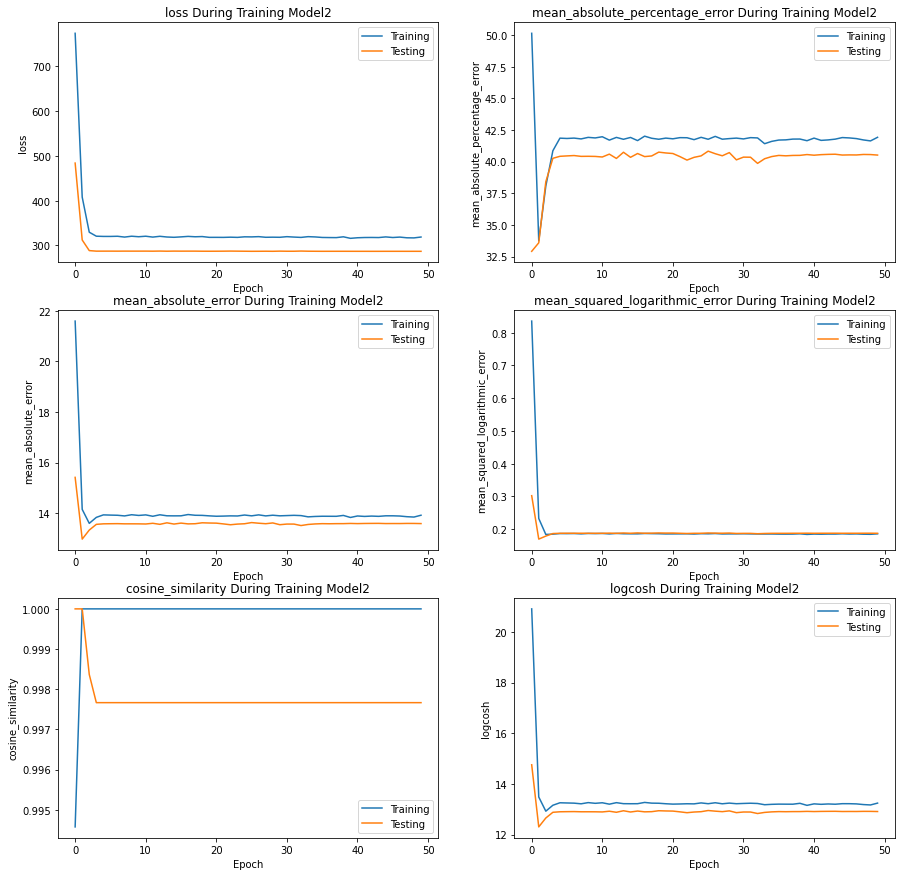

In [35]:
# === Plot the training and validation performance of model2 === #
metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Model2' )
    plt.legend( )

# === Display the Chart === #
plt.show( )

In [36]:
#A little memory management
del model2
gc.collect()


18849

## Task 3: Model 3:: CNN model with custom MSE loss (10pts)
* Let's define the Mean Squared Loss function ourselves and use it for the model training.
* As you know the Mean Squared Error (MSE) is the simplest and most commonly used loss function.
* The formula for MSE is 
$$ MSE(y,\hat{y}) = \dfrac{1}{N}\sum_{i=1}^N\left( y_i - \hat{y}_i\right)^2, $$
where $N$ is the total number of samples considered to compute this loss, $y$ and $\hat{y}$ are the ground-true target values and the corresponding predictions respectively.
    - MSE will never be negative, right?
    - Pros: Simplest to implement.
    - Cons: Very sensitive to outliers, or bad samples that might magnify the error too much that the gradient descent will have to experience hard-time converging/ going downhill, requiring extra steps (or longer routes). Simply speaking: slower training.
* More on MSE can be obtained here [Wiki: MSE](https://en.wikipedia.org/wiki/Mean_squared_error)

In [26]:
def TF_myMSE( y_true , y_pred ):
    # This function takes two numpy arrays / 1-D tensors of same length
    # And, it computes the MSE error. 
    # Please note, all the operations needs to be tensor operations to be able to use it during training.
    # Finally, it returns the mse error.
    
    mse_error = tf.constant(np.inf, dtype=tf.float32) #positive infinity
     # YOUR CODE HERE
        #https://github.com/tensorflow/tensorflow/issues/44555
        #https://github.com/tensorflow/tensorflow/issues/42242
#https://github.com/petewarden/tensorflow_makefile/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/tf.convert_to_tensor.md
    y_true = tf.convert_to_tensor(y_true,dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred,dtype=tf.float32)
    mse_error = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    return mse_error

In [28]:
# Just checking if you have defined the function correctly. A valid function will pass the 3 assertions quietly.
assert(np.abs(TF_myMSE([1, 2, 3, 4], [-1, -2, -3, -4]).numpy()-30.0) < 1e-3)
assert(np.abs(TF_myMSE([1, 2, 3, 4], [1, 2, 3, 4]).numpy()-0.0) < 1e-3)
assert(np.abs(TF_myMSE([41, 45, 49, 47, 44], [43.6, 44.4, 45.2, 46, 46.8]).numpy()- 6.079996) <1e-3)

In [31]:
# I've called my_CNN_model_A() function following the requirements above. 
# Please note: your defined custom MSE function (TF_myMSE) was passed for the training. 
# So, good luck!
# Please take a careful note at how it was called.
model3 = my_CNN_model_A(loss=TF_myMSE,
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

In [33]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard


epochs = 50 #number of epochs
batch_size = 128 #batch size

#training and test data ready for the training & validation
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#model save prefix
model_path = 'saved_models/model3.sav'

#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

In [36]:
# Now, call the lets_train_model() above with appropriate parameters to train model3.
# Please store the list of [history, model3] returned from the call.

# YOUR CODE HERE
#https://github.com/udacity/CN-ML_SageMaker_Studies/blob/master/Project_Plagiarism_Detection/source_pytorch/train.py
#https://github.com/huggingface/transformers/blob/master/src/transformers/trainer.py
#https://github.com/FunctionLab/selene/blob/master/selene_sdk/train_model.py

history, model3 = lets_train_model(model3, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks=callbacks)

Epoch 1/50
268/268 [==============================] - 20s 48ms/step - loss: 778.5491 - mean_absolute_percentage_error: 50.6160 - mean_absolute_error: 21.7380 - mean_squared_logarithmic_error: 0.8629 - cosine_similarity: 0.9935 - logcosh: 21.0561 - val_loss: 498.0468 - val_mean_absolute_percentage_error: 33.3667 - val_mean_absolute_error: 15.6434 - val_mean_squared_logarithmic_error: 0.3088 - val_cosine_similarity: 1.0000 - val_logcosh: 14.9822 - lr: 0.0010
Epoch 2/50
268/268 [==============================] - 12s 45ms/step - loss: 406.9640 - mean_absolute_percentage_error: 33.7151 - mean_absolute_error: 14.1605 - mean_squared_logarithmic_error: 0.2337 - cosine_similarity: 1.0000 - logcosh: 13.4930 - val_loss: 321.1091 - val_mean_absolute_percentage_error: 33.5138 - val_mean_absolute_error: 13.0361 - val_mean_squared_logarithmic_error: 0.1704 - val_cosine_similarity: 1.0000 - val_logcosh: 12.3630 - lr: 0.0010
Epoch 3/50
268/268 [==============================] - 12s 45ms/step - loss: 32

In [40]:
#Saving model3
save_model(model_path, model=model3, name='Model3', description='CNN-A with custom MSE loss')

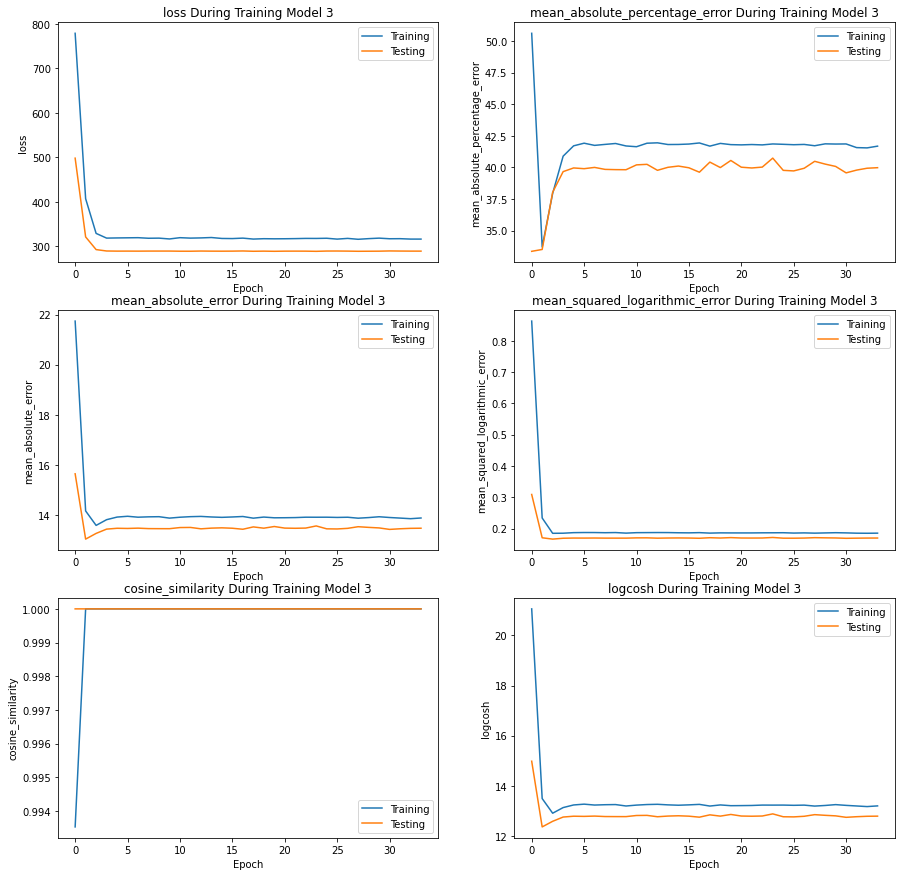

In [41]:
# === Plot the training and validation performance of model3 === #
metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Model 3' )
    plt.legend( )

# === Display the Chart === #
plt.show( )

In [42]:
# a little memory management 
del model3
gc.collect()


24365

## Task 4: Model 4:: CNN model with huber loss (10pts)
* Let's define another loss function, namely `huber loss`. 
* Proposed by Peter Huber in 1964 which is a compromise between the mean squared error and mean absolute error functions.
* It is a piece-wise function that behaves like Squared Error for small errors, and like Absolute Error for large errors.
$$ Huber(y,\hat{y}) = \begin{cases}
\frac{1}{2}(y-\hat{y})^2 & \textrm{for } | y - \hat{y}| \le \delta,\\
\delta\, (|y-\hat{y}|-\frac{1}{2}\delta), & \textrm{otherwise.}
\end{cases}
$$
    - Please compute mean of individual huber losses over the $N$ samples considered to compute the final Huber loss, $y$ and $\hat{y}$ are the ground-true target values and the corresponding predictions respectively.
* Peter Huber argued that, $\delta=1.345$ is a good choice, and showed that asymptotically, it is 95% as efficient as least squares (i.e., MSE) if the true distribution is Gaussian (i.e, normal), and much more efficient in many other cases.
* Below is the plots of both Huber loss (Green line, with $\delta =1$) and Squared error losses (blue line).You can see, Huber loss is also convex. Therefore, we can optimize through gradient descent. yah!! 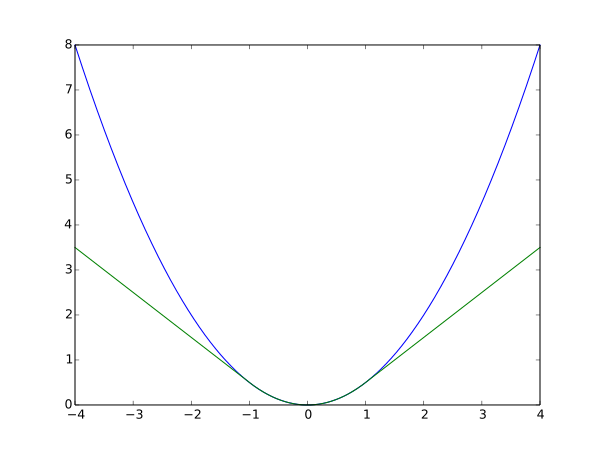
* More on this loss, here [Wiki:Huber loss](https://en.wikipedia.org/wiki/Huber_loss)

In [57]:
def TF_huber(y_true, y_pred, delta=1.345):
    # This function takes two numpy arrays / 1-D tensors of same length, a delta.
    # And, it computes the Huber loss. 
    # Please note, all the operations needs to be tensor operations to be able to use it during training.
    # Finally, it returns the huber loss.
    
    y_true = tf.cast(y_true, dtype=tf.float32) #converting to tf.float32 type
    y_pred = tf.cast(y_pred, dtype=tf.float32) #converting to tf.float32 type
    
    huber_loss = tf.constant(np.inf, dtype=tf.float32) #positive infinity
    
     # YOUR CODE HERE
    #https://www.tensorflow.org/api_docs/python/tf/math/abs
    #https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/math_ops.py
    #https://github.com/keras-team/keras/blob/master/keras/losses.py

    error = (y_true - y_pred)
    condition = tf.math.abs(error) < delta
    squared_loss = 0.5 * tf.square(error)
    linear_loss  = delta * (tf.math.abs(error) - 0.5 * delta)
    huber_loss =  tf.reduce_mean(tf.where(condition, squared_loss, linear_loss))

    return huber_loss

In [59]:
# Just checking if you have defined the function correctly. A valid function will pass the 3 assertions quietly.
assert(np.abs(TF_huber([1, 2, 3, 4], [-1, -2, -3, -4]).numpy()-5.8204875) < 1e-3)
assert(np.abs(TF_huber([1, 2, 3, 4], [1, 2, 3, 4]).numpy()-0.0) < 1e-3)
assert(np.abs(TF_huber([41, 45, 49, 47, 44], [43.6, 44.4, 45.2, 46, 46.8]).numpy()- 2.0680916) <1e-3)

In [60]:
# I've called my_CNN_model_A() function following the requirements above. 
# Please note: your defined custom huber loss function (TF_huber) was passed for the training. 
# So, good luck!
# Please take a careful note at how it was called.
model4 = my_CNN_model_A(loss=TF_huber,
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

In [61]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard


epochs = 50  #epoch number
batch_size = 128 #batch size

#training and validation dataset ready to be used for the model.fit()
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#model save prefix
model_path = 'saved_models/model4.sav'


#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

In [62]:
# Now, call the lets_train_model() above with appropriate parameters to train model4.
# Please store the list of [history, model4] returned from the call.

# YOUR CODE HERE
#https://github.com/huggingface/transformers/blob/master/src/transformers/trainer.py
#https://github.com/FunctionLab/selene/blob/master/selene_sdk/train_model.py
#https://github.com/FunctionLab/selene/blob/master/selene_sdk/train_model.py
history, model4 = lets_train_model(model4, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks=callbacks)

Epoch 1/50
268/268 [==============================] - 13s 47ms/step - loss: 25.7386 - mean_absolute_percentage_error: 45.2652 - mean_absolute_error: 19.7971 - mean_squared_logarithmic_error: 0.6716 - cosine_similarity: 0.9935 - logcosh: 19.1201 - val_loss: 18.5667 - val_mean_absolute_percentage_error: 31.4212 - val_mean_absolute_error: 14.4518 - val_mean_squared_logarithmic_error: 0.2507 - val_cosine_similarity: 1.0000 - val_logcosh: 13.7920 - lr: 0.0010
Epoch 2/50
268/268 [==============================] - 12s 45ms/step - loss: 17.8290 - mean_absolute_percentage_error: 33.3891 - mean_absolute_error: 13.9098 - mean_squared_logarithmic_error: 0.2200 - cosine_similarity: 1.0000 - logcosh: 13.2420 - val_loss: 16.7318 - val_mean_absolute_percentage_error: 32.4573 - val_mean_absolute_error: 13.0961 - val_mean_squared_logarithmic_error: 0.1771 - val_cosine_similarity: 1.0000 - val_logcosh: 12.4254 - lr: 0.0010
Epoch 3/50
268/268 [==============================] - 12s 46ms/step - loss: 17.274

In [63]:
#saving model4
save_model(model_path, model=model4, name='Model4', description='CNN-A with custom Huber loss')

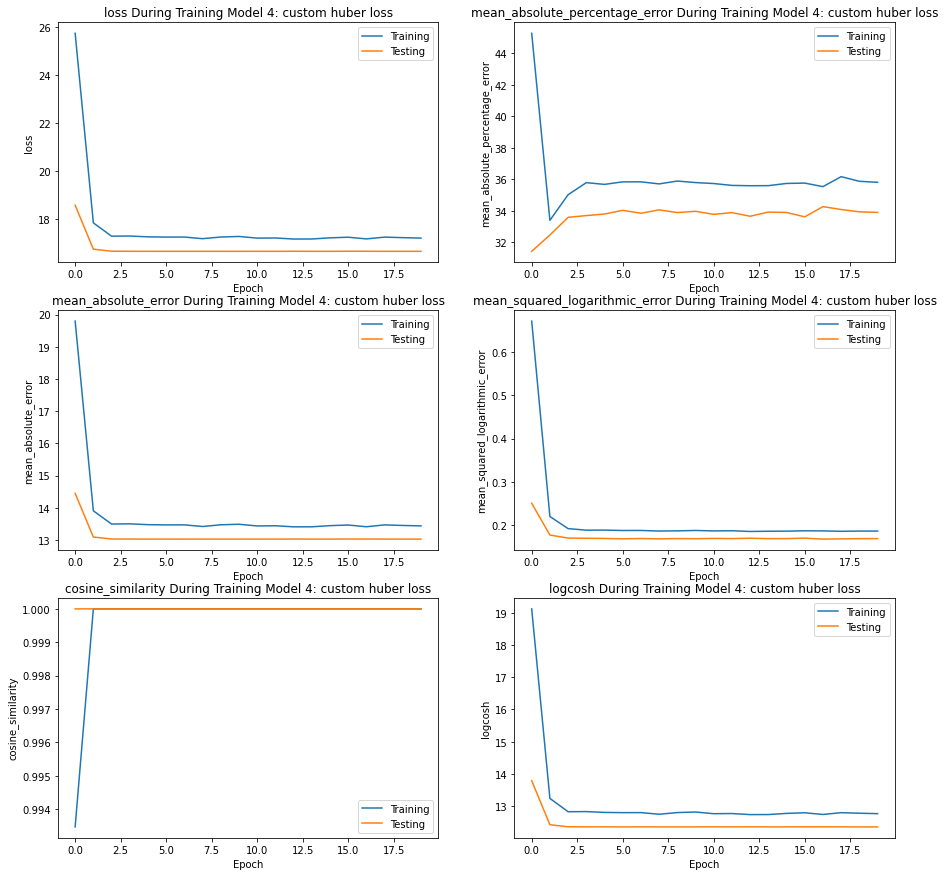

In [64]:
# === Plot the training and validation performance of model4 === #
metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Model 4: custom huber loss' )
    plt.legend( )

# === Display the Chart === #
plt.show( )

In [65]:
#a little memory management
del model4
gc.collect()

19824

## Task 5: Model 5:: CNN model with custom LogCosh loss (10pts)
* Log Cosh loss, i.e., log hyperbolic cosine loss is getting popular in regression problems with large target values, as you don't want to penalize too much if, for example, a house price is predicted USD 325,000 rather than USD 315,00. As you may have noticed there is an 10,000 prediction error, will be terribly amplified with losses like MSE. 
    - Pros:
        * `log(cosh(x))` approximates to $\frac{x^2}{2}$ for small $x$ and $|x|-\ln 2$ for large $x$. This means, the `logCosh` function works mostly like the mean squared error, but will not be so strongly affected by the occasional wildly incorrect/ large prediction errors. 
        * It has almost all advantages of the Huber loss, and it is twice differentiable everywhere, unlike Huber loss.
* Another appealing thing with this loss is it's double differentiable. Some optimizer, like XGBoost may prefer this property.
$$ LogCosh(y, \hat{y}) = \dfrac{1}{N}\sum_{i=1}^N  \log_e[\cosh(y_i - \hat{y}_i)]$$
    * And, you know, 
$$ \log_e \cosh(x) = \log_e(\cosh(x)), $$
where $$\cosh(x) = \dfrac{e^+e^{-x}}{2} = \dfrac{1+e^{-2x}}{2e^{-x}}=\dfrac{e^{2x}+1}{2e^x}$$
    * To ensure numerical stability, please use `tf.math.softplus` function rather than simply using `tf.math.exp` as `tf.math.exp` quickly overflows with slightly bigger inputs.
$$ \mathrm{softplus}(x) = \log_e(1+e^x)$$
    * Please use $\cosh(x) = \dfrac{1+e^{-2x}}{2e^{-x}}$ for positive $x$.
    * Also use $\cosh(x) = \dfrac{e^{2x}+1}{2e^x}$ for negative $x$.

Here below is the plots of both Huber and logcosh loss functions. Both are convex. 
    - 
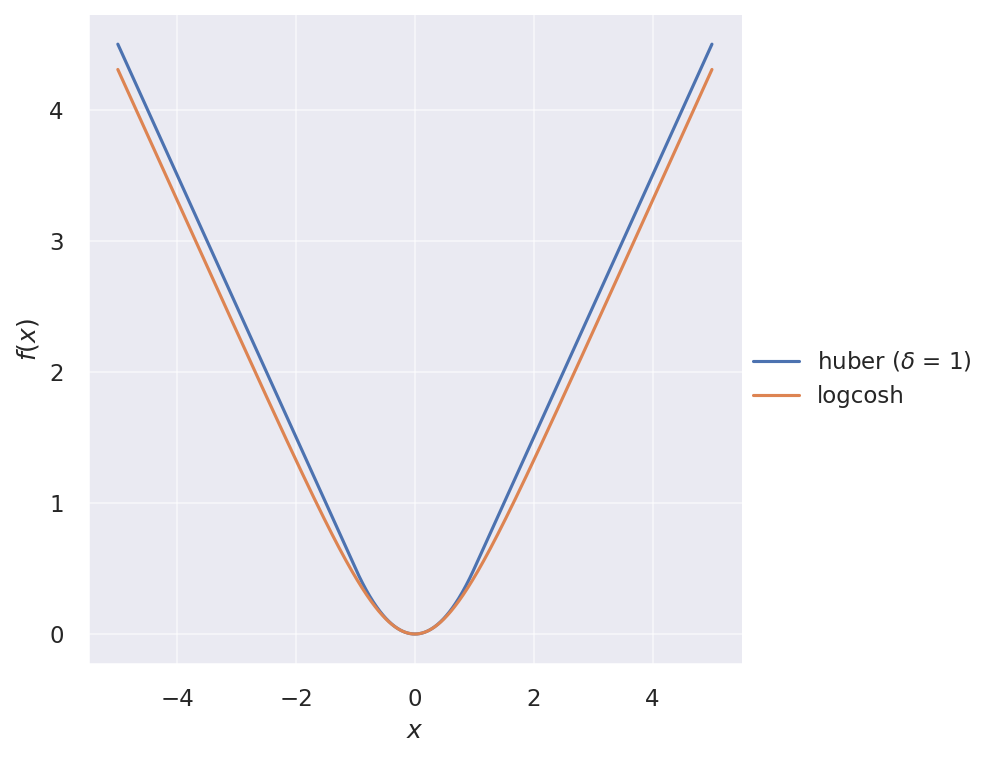

In [66]:
def TF_logcosh(y_true, y_pred):
    # This function takes two numpy arrays / 1-D tensors of same length, a delta.
    # And, it computes the LogCosh loss (y_true , y_pred). 
    # Please note, all the operations needs to be tensor operations to be able to use it during training.
    # Finally, it returns the logcosh loss.
    y_true = tf.cast(y_true, dtype=tf.float32) #cast to specific dtype
    y_pred = tf.cast(y_pred, dtype=tf.float32) #cast to specific dtype
    
    logcosh_loss = tf.constant(np.inf, dtype=tf.float32) #positive infinity
    # YOUR CODE HERE
    #https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/framework/constant_op.py

    error = (y_true - y_pred)
    loss = error + tf.math.softplus(-2. * error) - tf.cast(tf.math.log(2.), error.dtype)
    
    return tf.reduce_mean(loss)

In [67]:
# Just checking if you have defined the function correctly. A valid function will pass the 3 assertions quietly.
assert(np.abs(TF_logcosh([1, 2, 3, 4], [-1, -2, -3, -4]).numpy()-4.3114758) < 1e-3)
assert(np.abs(TF_logcosh([1, 2, 3, 4], [1, 2, 3, 4]).numpy()-0.0) < 1e-3)
assert(np.abs(TF_logcosh([41, 45, 49, 47, 44], [43.6, 44.4, 45.2, 46, 46.8]).numpy()- 1.5468327) <1e-3)

In [68]:
# I've called my_CNN_model_A() function following the requirements above. 
# Please note: your defined custom logcosh function (TF_logcosh) was passed for the training. 
# So, good luck!
# Please take a careful note at how it was called.
model5 = my_CNN_model_A(loss=TF_logcosh,
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

In [69]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard


epochs = 50 #number of epochs
batch_size = 128 #batch size

#train/validation data ready
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#saving path prefix
model_path = 'saved_models/model5.sav'

#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

In [70]:
# Now, call the lets_train_model() above with appropriate parameters to train model5.
# Please store the list of [history, model5] returned from the call.

# YOUR CODE HERE
#https://github.com/huggingface/transformers/blob/master/src/transformers/trainer.py
history, model5 = lets_train_model(model5, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks=callbacks)

Epoch 1/50
268/268 [==============================] - 13s 47ms/step - loss: 19.7618 - mean_absolute_percentage_error: 47.2345 - mean_absolute_error: 20.4400 - mean_squared_logarithmic_error: 0.7353 - cosine_similarity: 0.9930 - logcosh: 19.7618 - val_loss: 14.0575 - val_mean_absolute_percentage_error: 31.7744 - val_mean_absolute_error: 14.7188 - val_mean_squared_logarithmic_error: 0.2635 - val_cosine_similarity: 1.0000 - val_logcosh: 14.0575 - lr: 0.0010
Epoch 2/50
268/268 [==============================] - 12s 45ms/step - loss: 13.3260 - mean_absolute_percentage_error: 33.4193 - mean_absolute_error: 13.9938 - mean_squared_logarithmic_error: 0.2245 - cosine_similarity: 1.0000 - logcosh: 13.3260 - val_loss: 12.4526 - val_mean_absolute_percentage_error: 32.2338 - val_mean_absolute_error: 13.1229 - val_mean_squared_logarithmic_error: 0.1793 - val_cosine_similarity: 1.0000 - val_logcosh: 12.4526 - lr: 0.0010
Epoch 3/50
268/268 [==============================] - 12s 45ms/step - loss: 12.805

In [71]:
#saving model5
save_model(model_path, model=model5, name='Model5', description='CNN-A with custom LogCosh loss')


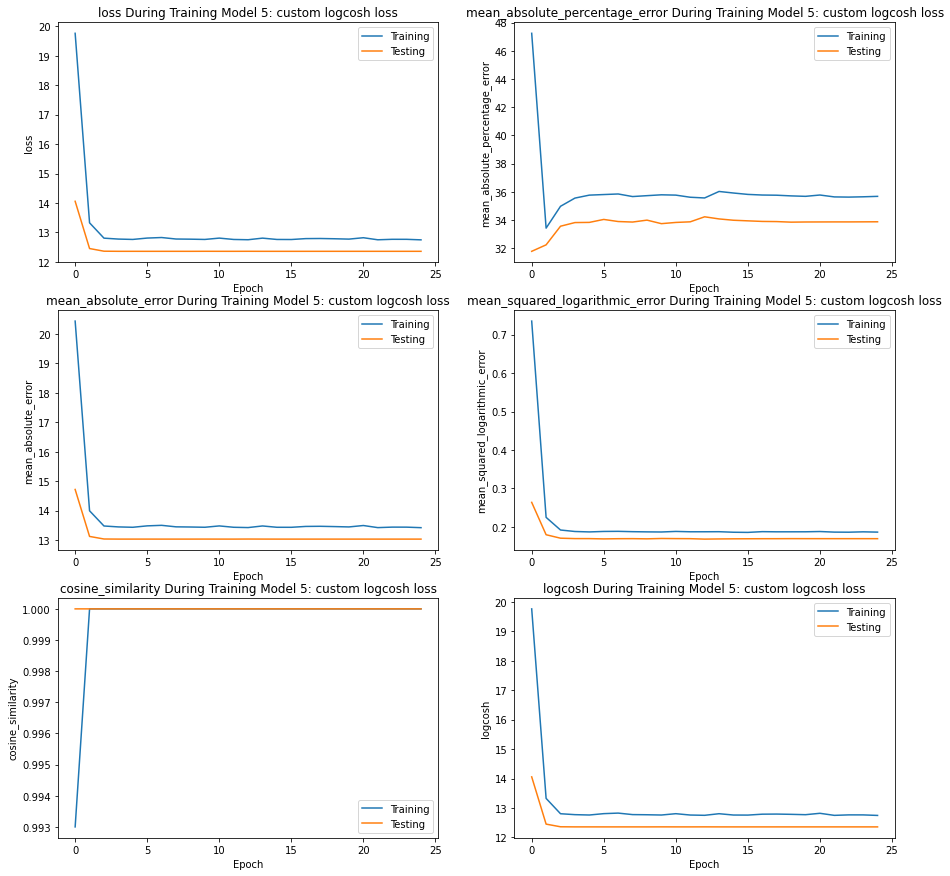

In [72]:
# === Plot the traing and validation performance of model 5 === #
metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Model 5: custom logcosh loss' )
    plt.legend( )

# === Display the Chart === #
plt.show( )

In [73]:
#a little memory-based housekeeping
del model5
gc.collect()

21921

## Task 6: Model 6:: CNN model with a custom loss, named "hubosh loss" (10pts)
* Let's define a new loss function, namely `hubosh` loss which combines both `huber` and `logcosh` losses. That is, 
$$ hubosh(y, \hat{y}) = huber(y,\hat{y}) + logcosh(y,\hat{y})$$
* The gradient descent during optimizing the `hubosh` loss will try to minimize the sum of `huber` and `logcosh` losses, in term minimizing both!
* Can you figure out whether `hubosh` loss would still be a convex function?

In [74]:
def TF_hubosh(y_true, y_pred, delta=1.345):
    # This function takes two numpy arrays / 1-D tensors of same length, a delta.
    # And, it computes the hubosh loss (y_true , y_pred). 
    # Please note, all the operations needs to be tensor operations to be able to use it during training.
    # Finally, it returns the logcosh loss.
    #y_true = tf.cast(y_true, dtype=tf.float32) #cast to a specific dtype
    #y_pred = tf.cast(y_pred, dtype=tf.float32) #cast to a specific dtype
    
    hubosh_loss = tf.constant(np.inf, dtype=tf.float32) #positive infinity
     # YOUR CODE HERE
    #https://www.tensorflow.org/api_docs/python/tf/keras/losses/LogCosh
    #https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/util/module_wrapper_test.py
    #https://www.tensorflow.org/api_docs/python/tf/keras/losses/log_cosh

    
    hubosh_loss = TF_logcosh(y_true, y_pred) + TF_huber(y_true, y_pred)
    
    return hubosh_loss 

In [75]:
# Just checking if you have defined the function correctly. A valid function will pass the 3 assertions quietly.
assert(np.abs(TF_hubosh([1, 2, 3, 4], [-1, -2, -3, -4]).numpy()-10.131964) < 1e-3)
assert(np.abs(TF_hubosh([1, 2, 3, 4], [1, 2, 3, 4]).numpy()-0.0) < 1e-3)
assert(np.abs(TF_hubosh([41, 45, 49, 47, 44], [43.6, 44.4, 45.2, 46, 46.8]).numpy()- 3.6149244) <1e-3)

In [76]:
# I've called my_CNN_model_A() function following the requirements above. 
# Please note: your defined custom hubosh function (TF_hubosh) was passed for the training. 
# So, good luck!
# Please take a careful note at how it was called.
model6 = my_CNN_model_A(loss=TF_hubosh,
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

In [77]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard


epochs = 50 #number of epochs
batch_size = 128 #batch size

#training and validation dataset are ready
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#model save prefix path
model_path = 'saved_models/model6.sav'

#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

In [78]:
# Now, call the lets_train_model() above with appropriate parameters to train model6.
# Please store the list of [history, model6] returned from the call.
# YOUR CODE HERE
#https://github.com/huggingface/transformers/blob/master/src/transformers/trainer.py
#https://github.com/udacity/CN-ML_SageMaker_Studies/blob/master/Project_Plagiarism_Detection/source_pytorch/train.py
history, model6 = lets_train_model(model6, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks=callbacks)

Epoch 1/50
268/268 [==============================] - 13s 47ms/step - loss: 46.5298 - mean_absolute_percentage_error: 47.1508 - mean_absolute_error: 20.5104 - mean_squared_logarithmic_error: 0.7404 - cosine_similarity: 0.9985 - logcosh: 19.8326 - val_loss: 33.1649 - val_mean_absolute_percentage_error: 31.8900 - val_mean_absolute_error: 14.7976 - val_mean_squared_logarithmic_error: 0.2673 - val_cosine_similarity: 1.0000 - val_logcosh: 14.1359 - lr: 0.0010
Epoch 2/50
268/268 [==============================] - 12s 45ms/step - loss: 31.2573 - mean_absolute_percentage_error: 33.4057 - mean_absolute_error: 13.9875 - mean_squared_logarithmic_error: 0.2252 - cosine_similarity: 1.0000 - logcosh: 13.3215 - val_loss: 29.1987 - val_mean_absolute_percentage_error: 32.3058 - val_mean_absolute_error: 13.1136 - val_mean_squared_logarithmic_error: 0.1785 - val_cosine_similarity: 1.0000 - val_logcosh: 12.4432 - lr: 0.0010
Epoch 3/50
268/268 [==============================] - 12s 45ms/step - loss: 30.065

In [79]:
#saving model6
save_model(model_path, model=model6, name='Model6', description='CNN-A with custom Hubosh loss')

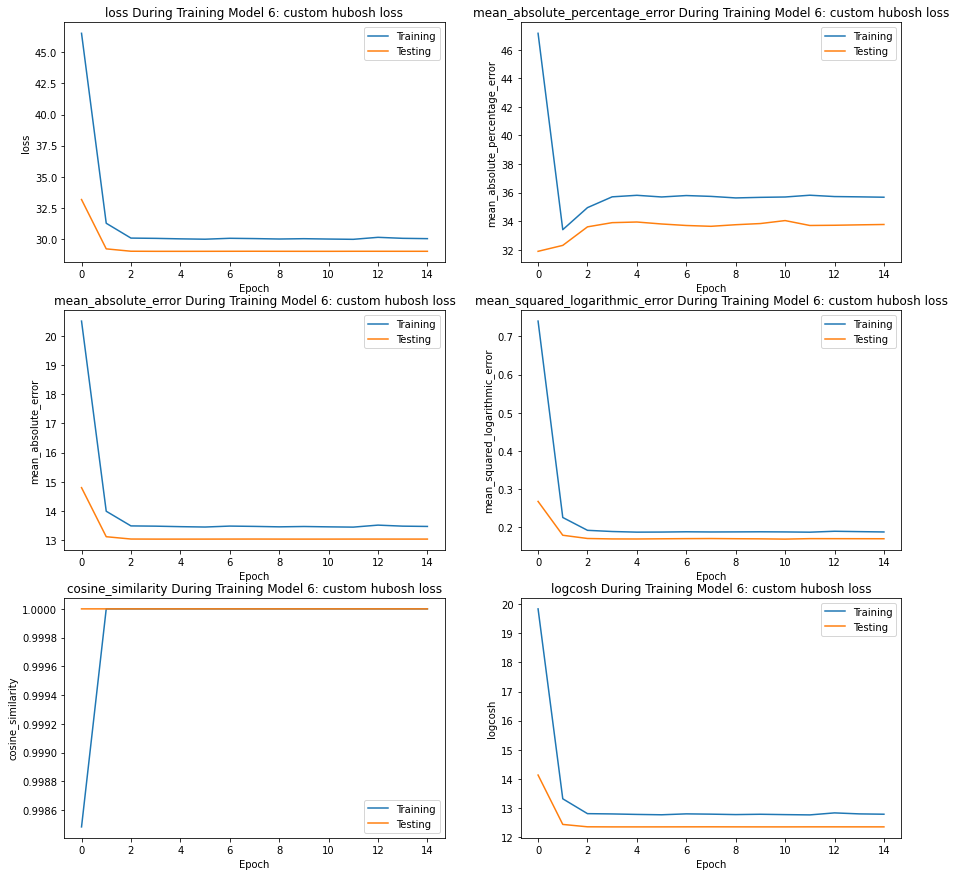

In [80]:
# === Plot the training and validation performance of model6 === #
metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Model 6: custom hubosh loss' )
    plt.legend( )

# === Display the Chart === #
plt.show( )

In [81]:
#a little housekeeping
del model6
gc.collect()

23801

## Task 7: Model 7:: Yet another CNN model, with MSE loss (10pts)


* Here below is CNN_C architecture. Please construct it.

Model: "sequential"

| Layer type| Output Shape | Param # (roughly)|
| :----------- | :----------- |------------|
Conv2D          |     (None, 98, 98, 32)   |     320       |
Conv2D          |     (None, 96, 96, 32)   |     9248      |
MaxPooling2D    |     (None, 48, 48, 32)   |    0          |
Conv2D          |     (None, 46, 46, 64)   |     18496     |
Conv2D          | (None, 44, 44, 64)       | 36928     |
MaxPooling2D    |  (None, 22, 22, 64)      |  0         |        
Conv2D          | (None, 20, 20, 128)      | 73856     |
Conv2D          | (None, 18, 18, 128)      |  147584    |
MaxPooling2D    | (None, 9, 9, 128)        | 0         |
Conv2D          | (None, 7, 7, 256)        | 295168    |
Conv2D          | (None, 5, 5, 256)        | 590080    |
MaxPooling2D    | (None, 2, 2, 256)        | 0         |
Flatten         | (None, 1024)             | 0         |
Dense           | (None, 32)               | 32800     |
Dense           | (None, 32)               | 1056      |
Dropout         |(None, 32)                | 0         |
Dense           | (None, 1)                | 33  |

In [98]:
def my_CNN_model_C(loss,optimizer,metrics):
    #construct the model following the architecture above and return the model
    # YOUR CODE HERE
    #https://github.com/artemkomarichev/a-cnn/blob/master/train.py
    #https://gist.github.com/JiaxiangZheng/a60cc8fe1bf6e20c1a41abc98131d518
    #https://github.com/ranahanocka/MeshCNN/blob/master/train.py
    #https://github.com/zhangruiskyline/DeepLearning/blob/master/doc/CNN.md
    #https://github.com/AlessandroSaviolo/CNN-from-Scratch
    
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    model.add(Conv2D(32, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    model.add(MaxPool2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    model.add(Conv2D(64, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    model.add(MaxPool2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    model.add(Conv2D(128, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    model.add(MaxPool2D((2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    model.add(Conv2D(256, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    model.add(MaxPool2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    # finally, compile with the provided optimizer to optimize the given loss object.
    # Also, list of metrics are going to be computed during each epoch.
    model.compile(loss=loss, 
                  optimizer=optimizer,
                  metrics=metrics)

    
    model.compile(loss=loss, 
                  optimizer=optimizer,
                  metrics=metrics)
    return model



In [99]:
# I've called my_CNN_model_C() function following the requirements above. 
# Please note: your defined built-in MSE function was passed for the training. 
# So, good luck!
# Please take a careful note at how it was called.

model7 = my_CNN_model_C(loss='mean_squared_error',
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

In [100]:
# Load the TensorBoard notebook extension
# YOUR CODE HERE
#https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
#https://github.com/lspvic/jupyter_tensorboard/tree/master/jupyter_tensorboard
#https://github.com/tensorflow/tensorboard/blob/master/tensorboard/notebook.py

%reload_ext tensorboard


epochs = 50 #number of epochs
batch_size = 128 #batch size

#training and validation dataset are ready
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#model save prefix path
model_path = 'saved_models/model7.sav'

#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

In [101]:
# YOUR CODE HERE
# Now, call the lets_train_model() above with appropriate parameters to train model7.
# Please store the list of [history, model7] returned from the call.
#https://github.com/udacity/CN-ML_SageMaker_Studies/blob/master/Project_Plagiarism_Detection/source_pytorch/train.py
#https://github.com/huggingface/transformers/blob/master/src/transformers/trainer.py
history, model7 = lets_train_model(model7, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks=callbacks)

Epoch 1/50
268/268 [==============================] - 26s 93ms/step - loss: 722.3514 - mean_absolute_percentage_error: 47.3348 - mean_absolute_error: 20.5341 - mean_squared_logarithmic_error: 0.7404 - cosine_similarity: 0.9953 - logcosh: 19.8549 - val_loss: 461.4488 - val_mean_absolute_percentage_error: 32.0270 - val_mean_absolute_error: 14.8873 - val_mean_squared_logarithmic_error: 0.2717 - val_cosine_similarity: 1.0000 - val_logcosh: 14.2253 - lr: 0.0010
Epoch 2/50
268/268 [==============================] - 25s 92ms/step - loss: 386.3409 - mean_absolute_percentage_error: 33.8950 - mean_absolute_error: 13.8586 - mean_squared_logarithmic_error: 0.2172 - cosine_similarity: 1.0000 - logcosh: 13.1900 - val_loss: 311.9835 - val_mean_absolute_percentage_error: 34.4175 - val_mean_absolute_error: 13.0372 - val_mean_squared_logarithmic_error: 0.1674 - val_cosine_similarity: 1.0000 - val_logcosh: 12.3622 - lr: 0.0010
Epoch 3/50
268/268 [==============================] - 25s 92ms/step - loss: 32

In [102]:
# YOUR CODE HERE
#https://github.com/floydhub/save-and-resume/blob/master/keras_mnist_cnn.py

save_model(model_path, model=model7, name='Model7', description='Yet another CNN with custom loss')

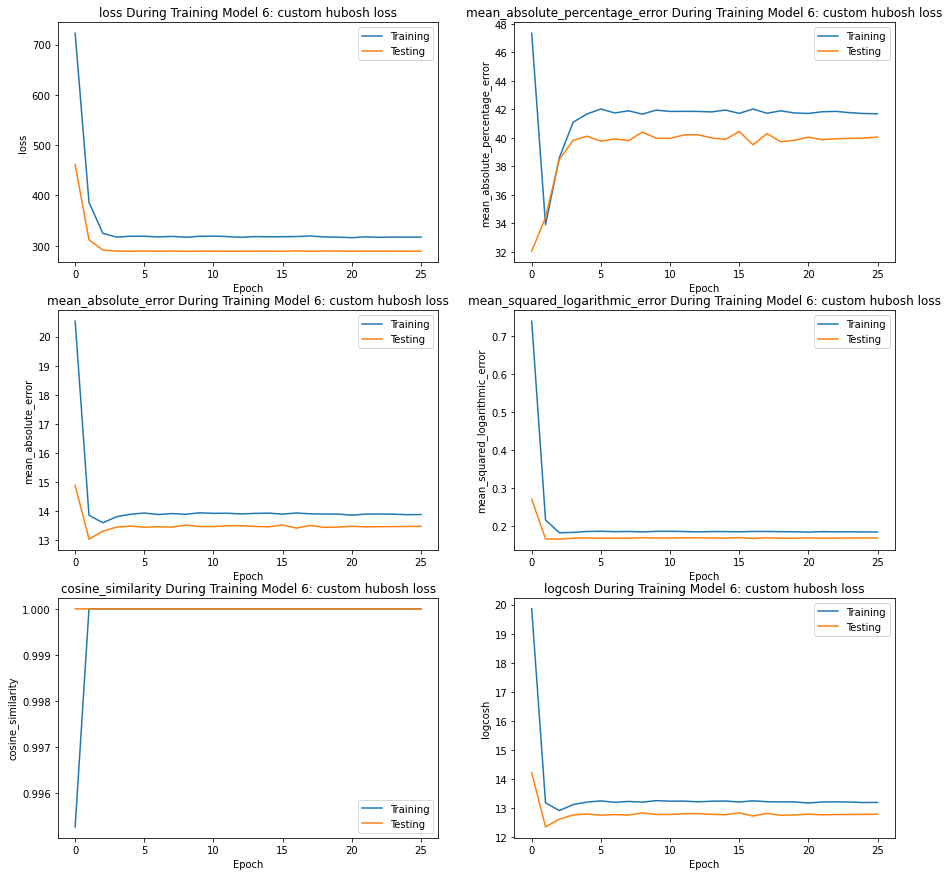

In [103]:
# YOUR CODE HERE
#https://github.com/zhihanyang2022/cnnvis
#https://github.com/mdeff/cnn_graph/blob/master/usage.ipynb

metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Model 6: custom hubosh loss' )
    plt.legend( )

# === Display the Chart === #
plt.show( )

In [104]:
#a little housekeeping
del model7
gc.collect()

26768

## Task 8: Evaluating all 7 models against the judge dataset (10pts)

In [105]:
# Loading the judge dataset
judge_info = pd.read_csv( 'dataset/wiki_judge.csv' )
judge_info.head( )

,ID,full_path,gender,face_score,second_face_score
0,1,['1.png'],1.0,2.645639,1.949248
1,3,['3.png'],1.0,5.471801,NaN
2,4,['4.png'],1.0,3.582895,NaN
3,5,['5.png'],1.0,1.529254,NaN
4,6,['6.png'],1.0,1.241739,NaN


In [106]:
#Loading the judge images
X_judge_images = np.zeros( shape = (len(judge_info),100,100),dtype=np.float32)

i = 0
for p in judge_info.full_path:
    p = p.replace('[','').replace(']','').replace('\'','')
    fpath = '{}/{}'.format('dataset/wiki_judge/',p)
    X_judge_images[i] = cv2.imread(fpath,cv2.IMREAD_GRAYSCALE) / 255.0
    i += 1

print(X_judge_images.shape)
X_judge_images = X_judge_images.reshape(
    X_judge_images.shape[0],
    X_judge_images.shape[1],
    X_judge_images.shape[2],
    1
)
print(X_judge_images.shape)

(1399, 100, 100)
(1399, 100, 100, 1)


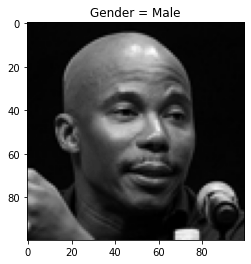

In [107]:
#Pick a random number and display it.
idx = random.randint(0,X_judge_images.shape[0])
img = X_judge_images[idx]
plt.figure()
plt.imshow(img.squeeze(), cmap='gray')
if judge_info.gender[idx]==0:
    gender = 'Female'
elif judge_info.gender[idx]==1:
    gender = 'Male'
else:
    gender = 'Unknown'
plt.title('Gender = {}'.format(gender))
plt.show()

In [132]:
# YOUR CODE HERE
#https://github.com/terpiljenya/import-glob
#https://stackoverflow.com/questions/2186525/how-to-use-glob-to-find-files-recursively

import glob as gb

model_dirs = [
    'saved_models/model1.sav',
    'saved_models/model2.sav',
    'saved_models/model3.sav',
    'saved_models/model4.sav',
    'saved_models/model5.sav',
    'saved_models/model6.sav',
    'saved_models/model7.sav',
]

model_accuracy_details = {}
for index, model_dir in enumerate(model_dirs):
    model,model_name, model_description = load_model(model_dir)
    
    y_predict = model.predict(X_test_images)
    y_actual = y_test
    
    mse = mean_squared_error(y_actual.tolist(),list(y_predict.reshape(1,-1)))
    model_accuracy_details[model_name] = float(mse)

model_accuracy_details

{'Model1': 288.9420166015625,
 'Model2': 294.0677795410156,
 'Model3': 288.75225830078125,
 'Model4': 316.23052978515625,
 'Model5': 316.0773010253906,
 'Model6': 316.4454345703125,
 'Model7': 288.8642272949219}

In [133]:
sorted(model_accuracy_details.items(),key=lambda x:x[1])

[('Model3', 288.75225830078125),
 ('Model7', 288.8642272949219),
 ('Model1', 288.9420166015625),
 ('Model2', 294.0677795410156),
 ('Model5', 316.0773010253906),
 ('Model4', 316.23052978515625),
 ('Model6', 316.4454345703125)]

## Task 9: Can you do better than all of these 7 models? Try here... (10pts)

In [149]:
#https://github.com/artemkomarichev/a-cnn/blob/master/train.py
#https://github.com/ranahanocka/MeshCNN/blob/master/train.py
#https://github.com/AlessandroSaviolo/CNN-from-Scratch
#https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65
#from keras.models import Sequential
#from keras.layers import Conv2D, MaxPooling2D

def your_model_fn(loss,optimizer,metrics):
    your_model = Sequential()

    your_model.add(Conv2D(32, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    your_model.add(Conv2D(32, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    your_model.add(BatchNormalization())
    your_model.add(Dropout(0.5))
    your_model.add(MaxPool2D((2, 2)))

    your_model.add(Conv2D(64, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    your_model.add(Conv2D(64, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    your_model.add(BatchNormalization())
    your_model.add(Dropout(0.5))
    your_model.add(MaxPool2D((2, 2)))

    your_model.add(Conv2D(128, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    your_model.add(Conv2D(128, (3, 3), activation='tanh', input_shape=(100, 100, 1)))
    your_model.add(BatchNormalization())
    your_model.add(Dropout(0.5))
    your_model.add(MaxPool2D((2, 2)))

    your_model.add(Flatten())
    your_model.add(Dense(64, activation='tanh'))
    your_model.add(Dropout(0.2))
    your_model.add(Dense(1))
    # finally, compile with the provided optimizer to optimize the given loss object.
    # Also, list of metrics are going to be computed during each epoch.
    your_model.compile(loss=loss, 
                  optimizer=optimizer,
                  metrics=metrics)

    return your_model



your_model1 = your_model_fn(loss='mean_squared_error',
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

your_model1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 conv2d_99 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization_23 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_38 (Dropout)        (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 46, 46, 64)      

In [150]:
%reload_ext tensorboard


epochs = 50 #number of epochs
batch_size = 128 #batch size

#training and validation dataset are ready
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#model save prefix path
model_path = 'saved_models/model8.sav'

#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]


history, your_model1 = lets_train_model(your_model1, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks=callbacks)

Epoch 1/50
268/268 [==============================] - 32s 116ms/step - loss: 747.5209 - mean_absolute_percentage_error: 48.4430 - mean_absolute_error: 21.0605 - mean_squared_logarithmic_error: 0.7742 - cosine_similarity: 0.9940 - logcosh: 20.3803 - val_loss: 480.5477 - val_mean_absolute_percentage_error: 32.6761 - val_mean_absolute_error: 15.2746 - val_mean_squared_logarithmic_error: 0.2906 - val_cosine_similarity: 1.0000 - val_logcosh: 14.6121 - lr: 0.0010
Epoch 2/50
268/268 [==============================] - 31s 114ms/step - loss: 385.1924 - mean_absolute_percentage_error: 32.6710 - mean_absolute_error: 13.6785 - mean_squared_logarithmic_error: 0.2104 - cosine_similarity: 1.0000 - logcosh: 13.0120 - val_loss: 315.3003 - val_mean_absolute_percentage_error: 34.0892 - val_mean_absolute_error: 13.0359 - val_mean_squared_logarithmic_error: 0.1686 - val_cosine_similarity: 1.0000 - val_logcosh: 12.3621 - lr: 0.0010
Epoch 3/50
268/268 [==============================] - 31s 114ms/step - loss:

In [151]:
judge_pred = your_model.predict( X_judge_images)

# === Construct Dataframe from Dictionary === #
judge_pred_df = pd.DataFrame( {
                                'ID': judge_info['ID'],
                                'age': judge_pred.flatten( )
                              })
#Saving the judge_pred_df dataframe into 'dataset/judge_pred_df.csv' file.
judge_pred_df.to_csv( 'saved_models/judge_pred_df_yourModel.csv' , index=False )

In [1]:
##Now predict the judge-set
judge_pred = your_model.predict( X_judge_images)

# === Construct Dataframe from Dictionary === #
judge_pred_df = pd.DataFrame( {
                                'ID': judge_info['ID'],
                                'age': judge_pred.flatten( )
                              })
#Saving the judge_pred_df dataframe into 'dataset/judge_pred_df.csv' file.
judge_pred_df.to_csv( 'saved_models/judge_pred_df_yourModel.csv' , index=False )
#Checking your judge predictions to put some score.
files = {'judge_pred': open('saved_models/judge_pred_df_yourModel.csv', 'rb')}
response = requests.post(
                            url='http://54.160.44.72/csci5931sp22/check-PA2-judge-pred.php', 
                            files=files,
                            data = {'submit':'submit'})
assert response.ok == True
print("Your Model:\n")
print(response.text)
print("\n")

NameError: name 'your_model' is not defined

# That's all. Thanks for your work... :)

Now, do the following to earn credit --
1. please hit the 'Save' button, or go "File > Save and Checkpoint" menu option to save the notebook.
2. Submit this notebook "PA2-assignment.ipynb" into Canvas "Assignment 2" entry. 
3. Done! You will receive a grade in the next 2-3 academic days.
